# Downloading dataset

In [ ]:
# Install the Kaggle library
!pip install -q kaggle

# Upload your kaggle.json file
from google.colab import files
files.upload()

# Create the .kaggle directory and move the file
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset name (you can verify this on the Kaggle page)
DATASET_NAME = 'puneet6060/intel-image-classification'

# Download the dataset
!kaggle datasets download -d {DATASET_NAME}

# Unzip the files
import zipfile
with zipfile.ZipFile('intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('intel_images')

# Now the data is in the 'intel_images' directory in the Colab file system.

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 91% 314M/346M [00:01<00:00, 208MB/s] 
100% 346M/346M [00:05<00:00, 63.7MB/s]


# Transfer Learning (MobileNetV2)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.utils import class_weight

# --- 1. DATASET & AUGMENTATION ---
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

train_ds = tf.keras.utils.image_dataset_from_directory(
    'intel_images/seg_train/seg_train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'intel_images/seg_test/seg_test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

CLASS_NAMES = train_ds.class_names

# --- 2. CLASS WEIGHTS ---
labels = np.concatenate([y for x, y in train_ds], axis=0)
labels_int = np.argmax(labels, axis=1)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_int), y=labels_int)
class_weights_dict = dict(enumerate(weights))

# --- 3. CALLBACKS (Early Stopping) ---
# We monitor 'val_loss'. If it doesn't improve for 3 epochs, training stops.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,           # Gives it room to find a better path
    min_delta=0.005,      # Improvement must be > 0.5% to count as "progress"
    restore_best_weights=True,
    verbose=1
)

# --- 4. MODEL BUILDING & INITIAL TRAINING ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# --- REVISED MODEL BUILDING (Functional API) ---

# 1. Define the input layer explicitly
inputs = tf.keras.Input(shape=(150, 150, 3))

# 2. Chain the layers together
x = data_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1.0)(x)

# IMPORTANT: training=False ensures the base_model behaves correctly
# even during the fine-tuning phase for its internal BatchNormalization layers.
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

# 3. Create the model
model2 = tf.keras.Model(inputs, outputs)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Starting Initial Training...")
history_initial = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stop] # Added Early Stopping here
)

# --- 5. FINE-TUNING ---
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting Fine-Tuning...")
history_fine = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[early_stop] # Added Early Stopping here as well
)


model2.save("model_functional_final.keras")

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


/tmp/ipython-input-1638318804.py:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Starting Initial Training...
Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.7736 - loss: 0.6882 - val_accuracy: 0.8787 - val_loss: 0.3461
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.8478 - loss: 0.4098 - val_accuracy: 0.8863 - val_loss: 0.3010
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8611 - loss: 0.3649 - val_accuracy: 0.8977 - val_loss: 0.2771
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8758 - loss: 0.3381 - val_accuracy: 0.8973 - val_loss: 0.2787
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8775 - loss: 0.3273 - val_accuracy: 0.8990 - val_loss: 0.2763
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8765 - loss: 0.3267 - val_accuracy: 0.8967 - val_loss: 0.2793
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8788 - loss: 0.3206 - val_accuracy: 0.8970 - val_loss: 0.2925
Epoch 8/30
4

# Training Vs Validation Curves

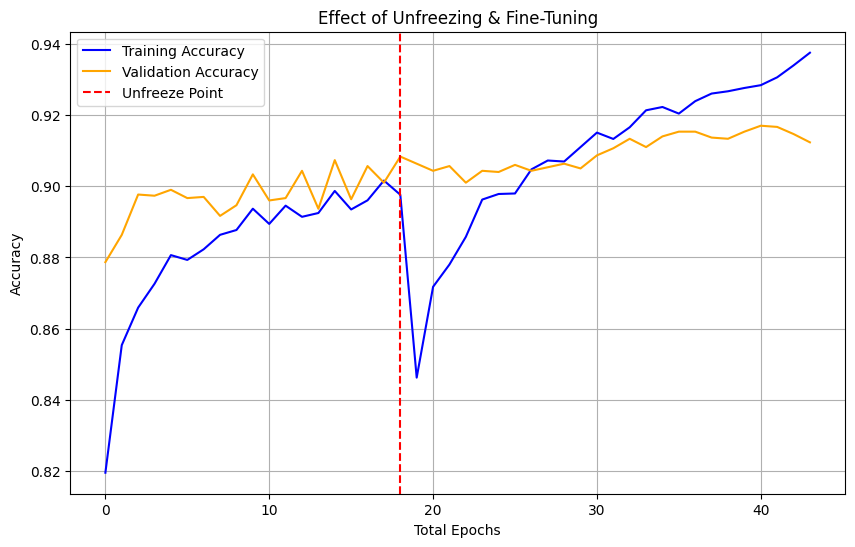

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_history(h1, h2):
    # Join the lists from both training sessions
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']

    plt.figure(figsize=(10, 6))
    plt.plot(acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')

    # Mark the spot where you "Unfroze" the model
    plt.axvline(x=len(h1.history['accuracy'])-1, color='red', linestyle='--', label='Unfreeze Point')

    plt.title('Effect of Unfreezing & Fine-Tuning')
    plt.xlabel('Total Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
#history_fine_total_acc = history_fine.history['accuracy'] + history_extended.history['accuracy']
plot_combined_history(history_initial, history_fine)

In [ ]:
import shutil
# Replace 'path_to_model' with what you copied, and 'drive_folder' with your destination
shutil.move('/content/model.h5', '/content/drive/MyDrive/model.h5')

'/content/drive/MyDrive/model.h5'